In [22]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import shap
from keras.models import Sequential
from keras.layers import Dense
from shapely import Point, wkt

random_seed = 100

In [7]:
df = pd.read_csv('data/cleaned/df_ml_tb_rail.csv')

# transform to geodataframe using wkt on geometry
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:27700')

# get x and y coordinates
df['x_coords'] = df.centroid.x
df['y_coords'] = df.centroid.y

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    17342 non-null  object  
 1   geometry                   17342 non-null  geometry
 2   population                 17342 non-null  float64 
 3   poi_banking                17342 non-null  float64 
 4   poi_hotels                 17342 non-null  float64 
 5   poi_leisure_active         17342 non-null  float64 
 6   poi_leisure_entertainment  17342 non-null  float64 
 7   poi_leisure_outdoor        17342 non-null  float64 
 8   poi_medical                17342 non-null  float64 
 9   poi_nature                 17342 non-null  float64 
 10  poi_public_facilities      17342 non-null  float64 
 11  poi_religious              17342 non-null  float64 
 12  poi_restaurants            17342 non-null  float64 
 13  poi_shopping           

In [31]:
# log transform the target variable
df['log_Total_railbus'] = df['Total_railbus'].apply(lambda x: 0 if x==0 else np.log(x))
df['log_Total_rail'] = df['Total_rail'].apply(lambda x: 0 if x==0 else np.log(x))
df['log_Total_bus'] = df['Total_bus'].apply(lambda x: 0 if x==0 else np.log(x))

In [28]:
# define target variable columns
targets = ['Total_railbus','Total_bus','Total_rail']
targets_log = ['log_Total_railbus','log_Total_bus','log_Total_rail']
# targets_tb_r = ['Early_rail', 'AM Peak_rail', 'Midday_rail', 'PM Peak_rail', 'Evening_rail', 'Late_rail']

# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'bus_degree','bus_closeness_t','bus_betweenness_t',
            'rail_degree','rail_closeness_t','rail_betweenness_t'
            ]
features_w_coords = features + ['x_coords','y_coords'] 

# 1. No log transformation

## 1.1 Correl

(500950.8766223728, 564298.121720478, 153943.01321221923, 203074.03445197854)

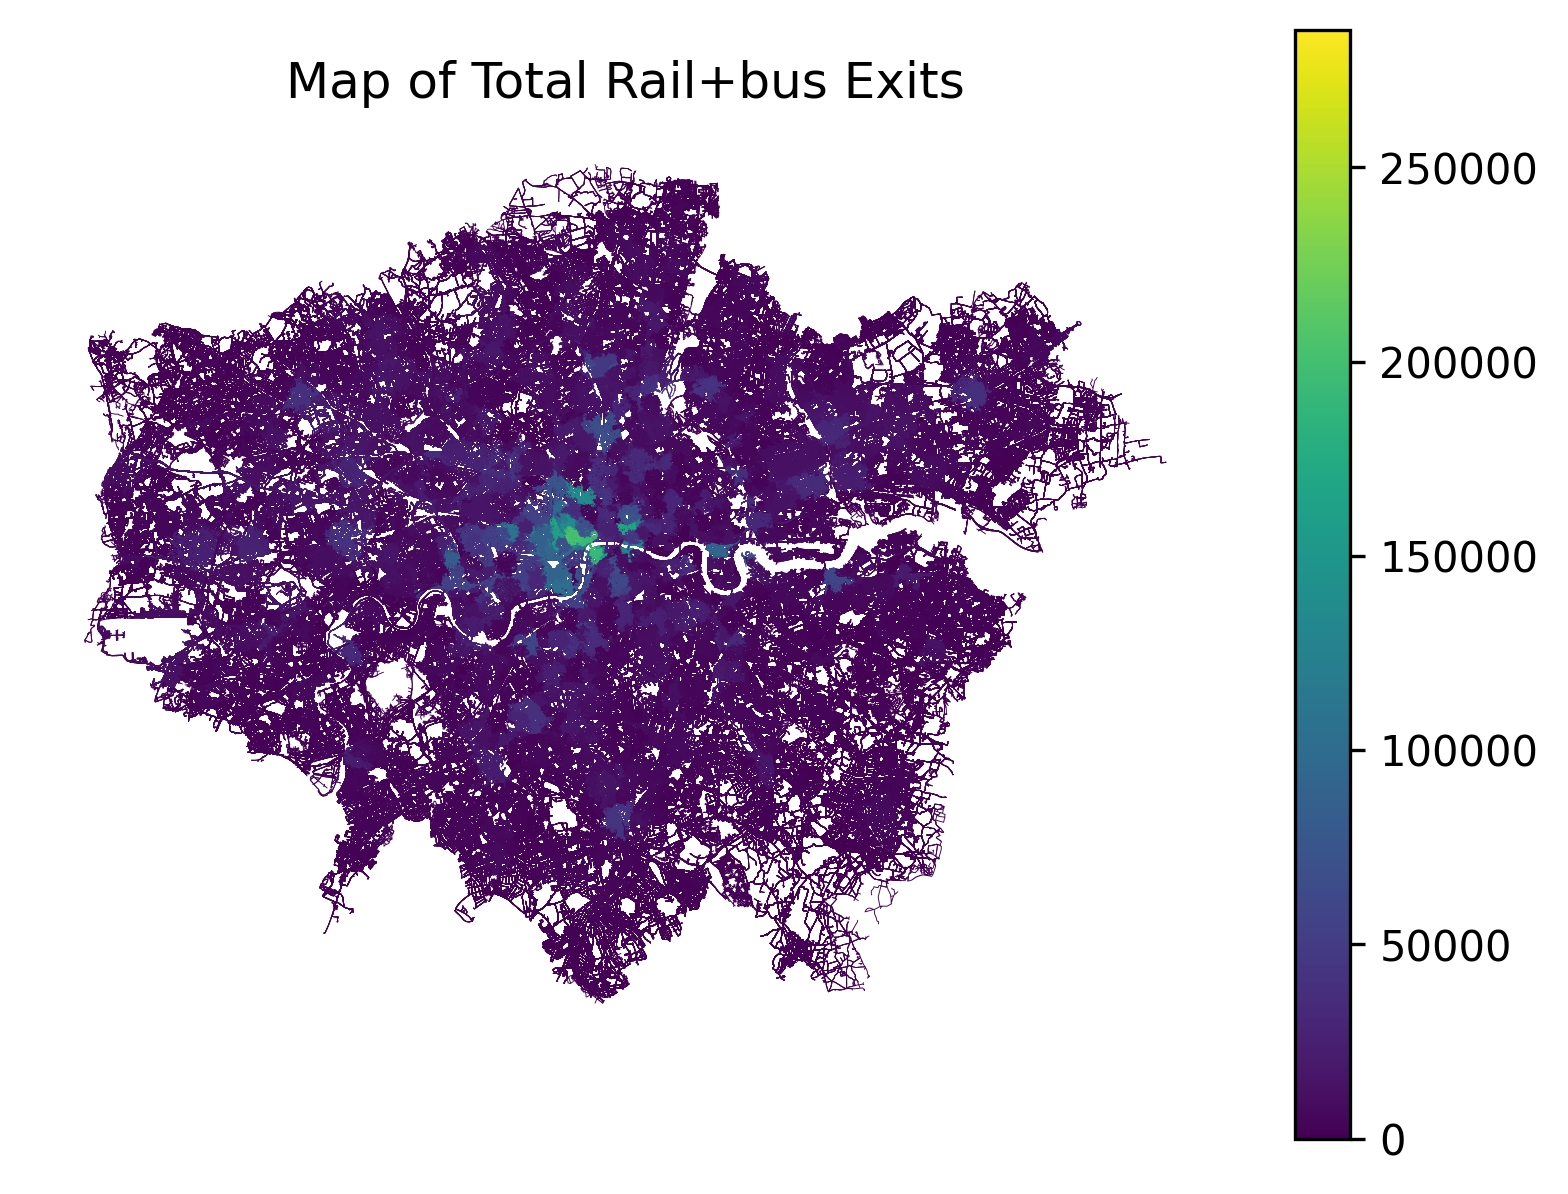

In [34]:
# Map target var
fig, ax = plt.subplots(dpi=300)
df.plot(ax=ax,column='Total_railbus',legend=True,figsize=(15,8),cmap='viridis')
plt.title("Map of Total Rail+bus Exits")
ax.axis('off')

Correlation matrix for Total_railbus


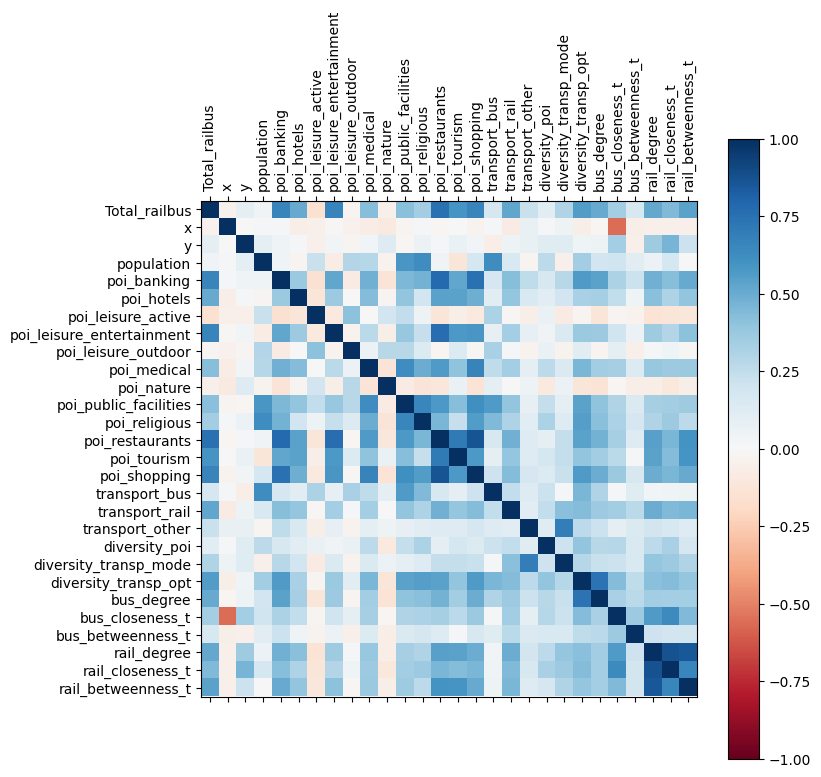

Correlation matrix for Total_bus


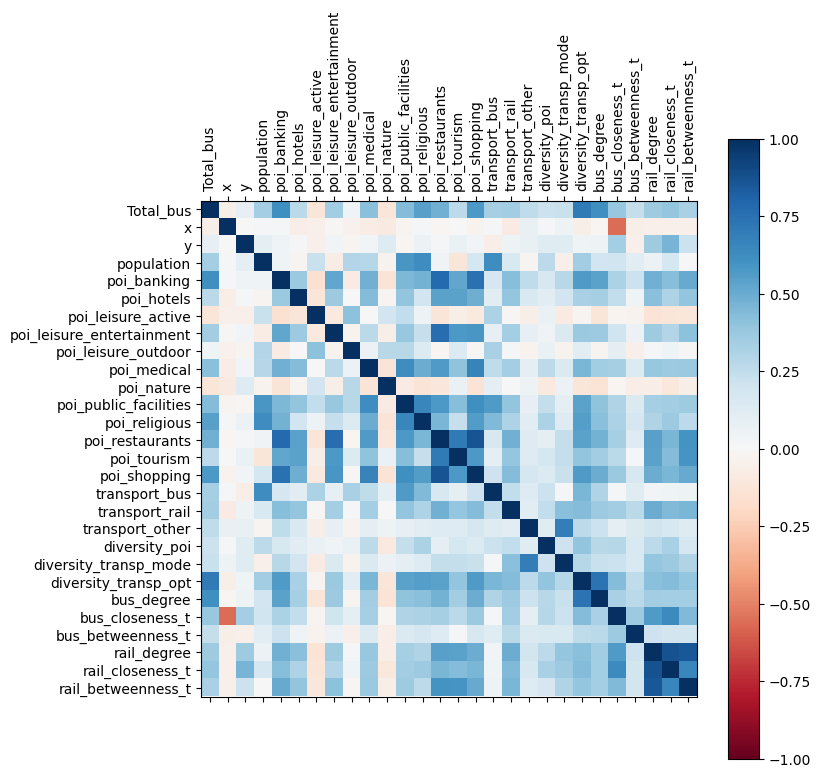

Correlation matrix for Total_rail


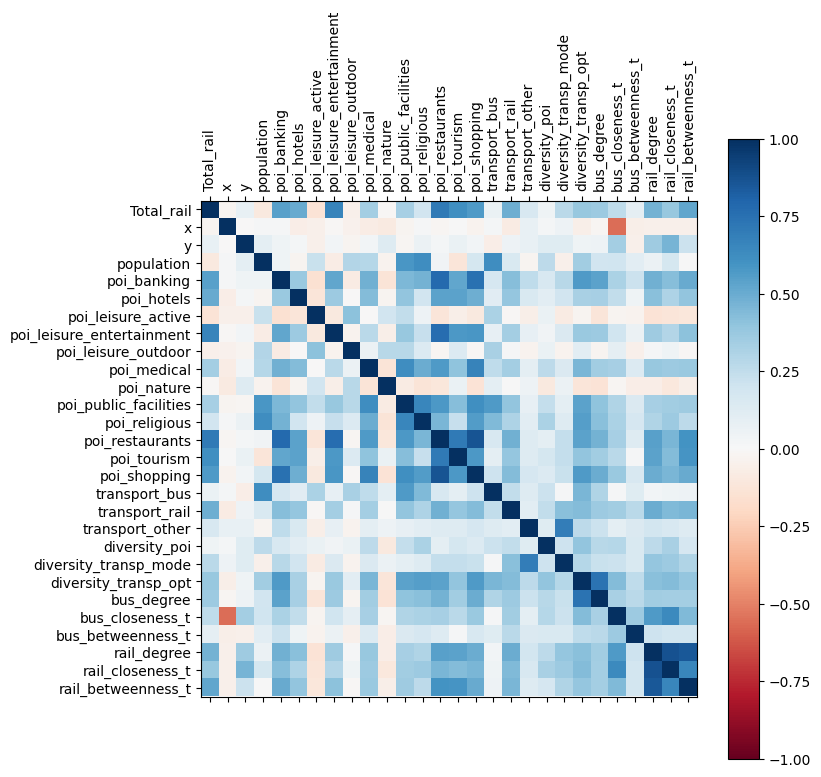

In [44]:
# for each of the target variable, create a correlation matrix graph
for tar in targets:
    print(f'Correlation matrix for {tar}')
    corr = df[[tar] + features_w_coords].corr()
    plt.figure(figsize=(8,8))
    # set 0 as middle value
    plt.matshow(corr, fignum=1, cmap='RdBu',vmin=-1,vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    
    # save the figure
    plt.savefig(os.path.join('output','corr',f'corr_{tar}.jpg'))
    plt.show()

## 1.2 Scikit-learn

Running model for total_bus_exits
Iteration 1, loss = 43518505.78100194
Validation score: -0.989832
Iteration 2, loss = 41225517.91926745
Validation score: -0.683676
Iteration 3, loss = 26552540.60567241
Validation score: 0.189272
Iteration 4, loss = 15329420.81808488
Validation score: 0.400004
Iteration 5, loss = 11657698.59337374
Validation score: 0.524816
Iteration 6, loss = 9518316.19035935
Validation score: 0.591305
Iteration 7, loss = 8386604.19542850
Validation score: 0.623187
Iteration 8, loss = 7760842.32021696
Validation score: 0.644218
Iteration 9, loss = 7366616.23350123
Validation score: 0.656031
Iteration 10, loss = 7094092.72465534
Validation score: 0.664874
Iteration 11, loss = 6883139.04302494
Validation score: 0.672684
Iteration 12, loss = 6713916.32891636
Validation score: 0.679725
Iteration 13, loss = 6585489.49361987
Validation score: 0.684655
Iteration 14, loss = 6456172.49127763
Validation score: 0.689524
Iteration 15, loss = 6349916.21766298
Validation score: 0.

C:\Users\shaun\AppData\Local\Temp\ipykernel_484\371043505.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,ddf])


  0%|          | 0/3469 [00:00<?, ?it/s]

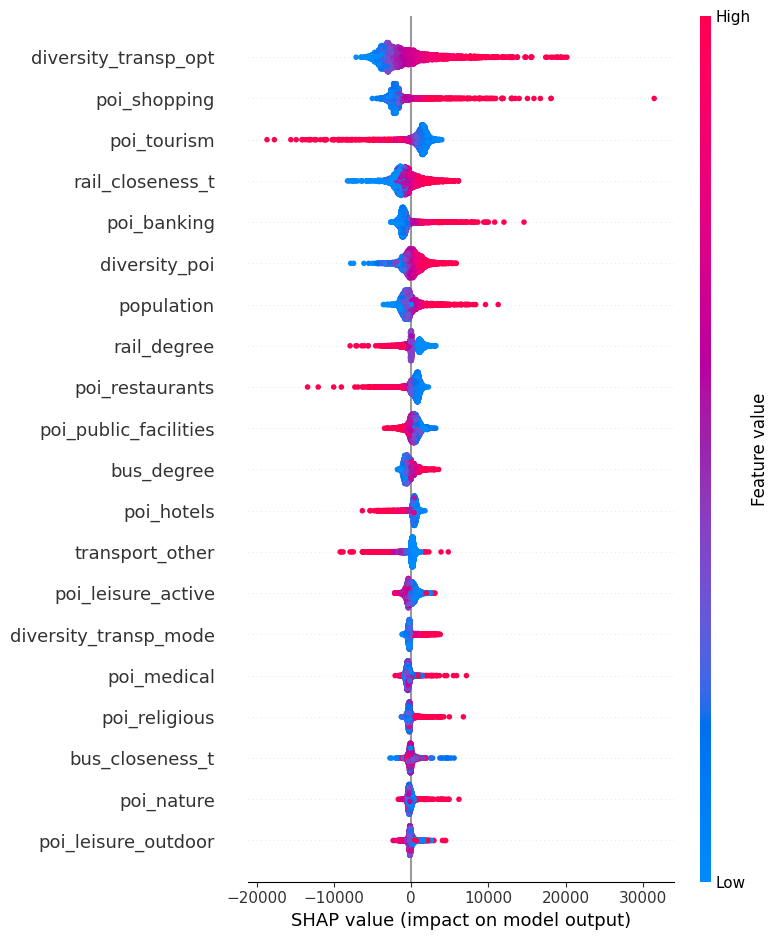

Running model for total_rail_exits
Iteration 1, loss = 131304853.34695926
Validation score: -0.098365
Iteration 2, loss = 128358728.92546511
Validation score: -0.026357
Iteration 3, loss = 102769281.73694795
Validation score: 0.331771
Iteration 4, loss = 61108454.46493667
Validation score: 0.551931
Iteration 5, loss = 51835314.66381983
Validation score: 0.591734
Iteration 6, loss = 49059728.75562619
Validation score: 0.614215
Iteration 7, loss = 47267279.65183971
Validation score: 0.630926
Iteration 8, loss = 46009369.51942322
Validation score: 0.642177
Iteration 9, loss = 45139715.76174082
Validation score: 0.652798
Iteration 10, loss = 44270020.64148227
Validation score: 0.664064
Iteration 11, loss = 43563952.13755503
Validation score: 0.669213
Iteration 12, loss = 43064626.48850331
Validation score: 0.678334
Iteration 13, loss = 42656764.56142244
Validation score: 0.686433
Iteration 14, loss = 42190003.54349735
Validation score: 0.686592
Iteration 15, loss = 41813257.24012046
Valida

  0%|          | 0/3469 [00:00<?, ?it/s]

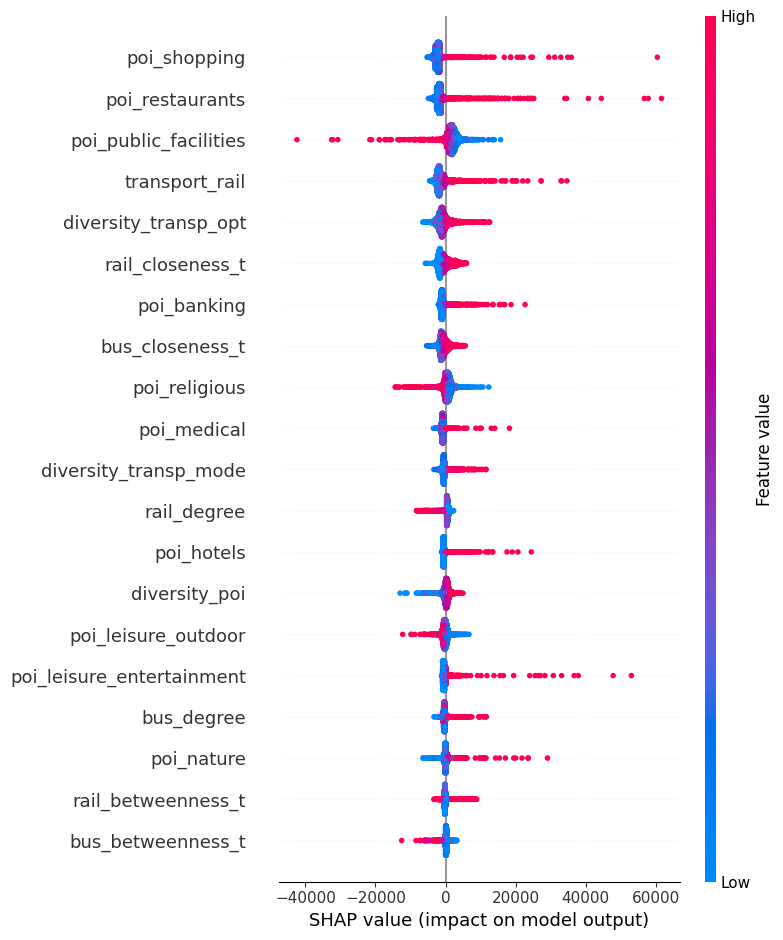

Running model for total_exits
Iteration 1, loss = 245573106.10405484
Validation score: -0.358462
Iteration 2, loss = 240010478.61452544
Validation score: -0.267170
Iteration 3, loss = 189095927.20547277
Validation score: 0.237078
Iteration 4, loss = 89759236.02906124
Validation score: 0.617435
Iteration 5, loss = 66832462.83458690
Validation score: 0.647732
Iteration 6, loss = 63544289.09996103
Validation score: 0.663949
Iteration 7, loss = 61091345.39868356
Validation score: 0.676633
Iteration 8, loss = 59048427.35039034
Validation score: 0.686892
Iteration 9, loss = 57414506.06897984
Validation score: 0.695764
Iteration 10, loss = 55984854.36681604
Validation score: 0.704131
Iteration 11, loss = 54755448.12383024
Validation score: 0.709014
Iteration 12, loss = 53811077.88532488
Validation score: 0.717810
Iteration 13, loss = 53126316.38265853
Validation score: 0.723222
Iteration 14, loss = 52356879.89736388
Validation score: 0.724099
Iteration 15, loss = 51762878.89082550
Validation 

  0%|          | 0/3469 [00:00<?, ?it/s]

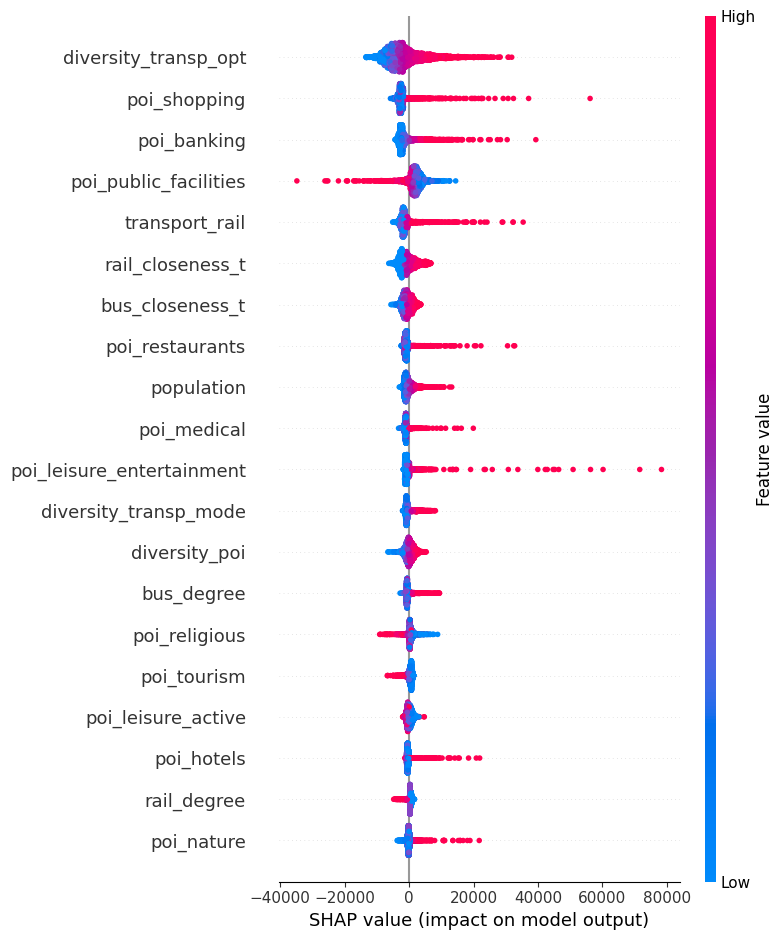

<Figure size 640x480 with 0 Axes>

In [70]:
# loop through all target variables, train the model and save the shap plot

results = pd.DataFrame(columns=['Target var','MSE','R2'])

for target in targets:
    print(f'Running model for {target}')
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    # scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  
    # create the model, 
    model = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(50,50,50), max_iter=1000, random_state=100, early_stopping=True, learning_rate='adaptive')

    # fit the model record train accuracy and test accuracy at each iteration
    model.fit(X_train,y_train)

    # predict the test data
    y_pred = model.predict(X_test)

    # how good is the model?
    print(f'MSE: {mean_squared_error(y_test,y_pred)}')
    print(f'R2: {r2_score(y_test,y_pred)}')

    # store the two values MSE and R2 in a dataframe for each target variable
    ddf = pd.DataFrame({'Target var':target,'MSE':mean_squared_error(y_test,y_pred),'R2':r2_score(y_test,y_pred)},index=[0])
    results = pd.concat([results,ddf])

    # explain all the predictions in the test set
    explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 50, random_state=random_seed))
    shap_values = explainer.shap_values(X_test, feature_names=features)

    # plot the shap values and save the plot
    shap.summary_plot(shap_values, X_test,feature_names=features)

In [73]:
results.reset_index(drop=True,inplace=True)
results.to_csv(os.path.join('output','results.csv'),index=False)
results

Target var           MSE        R2
0   total_bus_exits  5.566528e+06  0.868123
1  total_rail_exits  5.915576e+07  0.753757
2       total_exits  8.426019e+07  0.763824

## 1.3 Keras

In [12]:
results = pd.DataFrame(columns=['Target var','MSE','R2'])
model_list = []
shap_list = []

In [15]:
# fit model
for target in targets:
    print(f'Running model for {target}')
    X= df[features]
    y= df[target]

    # Split the data into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

    ### Sandardization of data ###
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # create ANN model
    krmodel = Sequential()
    krmodel.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    krmodel.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    krmodel.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    krmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    # Fitting the ANN to the Training set
    krmodel.fit(X_train, y_train ,batch_size = 20, epochs = 150, verbose=1, validation_data=(X_test, y_test))
    # save the model to a list
    model_list.append(krmodel)
    # predict the test data
    y_pred = krmodel.predict(X_test)

    # how good is the model?
    print(f'MSE: {mean_squared_error(y_test,y_pred)}')
    print(f'R2: {r2_score(y_test,y_pred)}')
    # store the two values MSE and R2 in a dataframe for each target variable
    ddf = pd.DataFrame({'Target var':target,'MSE':mean_squared_error(y_test,y_pred),'R2':r2_score(y_test,y_pred)},index=[0])
    results = pd.concat([results,ddf])

# view general results
results.reset_index(drop=True,inplace=True)
results.to_csv(os.path.join('output','results_kr_xy.csv'),index=False)
results

Running model for Total_railbus
Epoch 1/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 495629504.0000 - mean_squared_error: 495629664.0000 - val_loss: 478586144.0000 - val_mean_squared_error: 479688160.0000
Epoch 2/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 432989888.0000 - mean_squared_error: 432990016.0000 - val_loss: 373717856.0000 - val_mean_squared_error: 374492640.0000
Epoch 3/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 325383264.0000 - mean_squared_error: 325383392.0000 - val_loss: 237105616.0000 - val_mean_squared_error: 237456208.0000
Epoch 4/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 223899088.0000 - mean_squared_error: 223899216.0000 - val_loss: 170013952.0000 - val_mean_squared_error: 170158688.0000
Epoch 5/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 160795648.0000 - mean_squared_error: 160795584.0000 - val_loss: 153312208.0000 - val_mean_squared_error: 153404944.0000
Epoch 6/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14

C:\Users\shaun\AppData\Local\Temp\ipykernel_18928\2094723122.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,ddf])


607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 88315176.0000 - mean_squared_error: 88315176.0000 - val_loss: 81230408.0000 - val_mean_squared_error: 81242408.0000
Epoch 2/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 76609560.0000 - mean_squared_error: 76609576.0000 - val_loss: 55111420.0000 - val_mean_squared_error: 55049228.0000
Epoch 3/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50759708.0000 - mean_squared_error: 50759708.0000 - val_loss: 38130224.0000 - val_mean_squared_error: 38027108.0000
Epoch 4/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37088844.0000 - mean_squared_error: 37088844.0000 - val_loss: 32842418.0000 - val_mean_squared_error: 32731514.0000
Epoch 5/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33071994.0000 - mean_squared_error: 33071986.0000 - val_loss: 29594806.0000 - val_mean_squared_error: 29478850.0000
Epoch 6/150
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 29951364.0000 - mean_squared_error: 29951368.0000 - val_loss: 2699

Target var           MSE        R2
0  Total_railbus  9.927579e+07  0.725912
1      Total_bus  1.091105e+07  0.744744
2     Total_rail  7.443257e+07  0.695946

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/5203 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/12

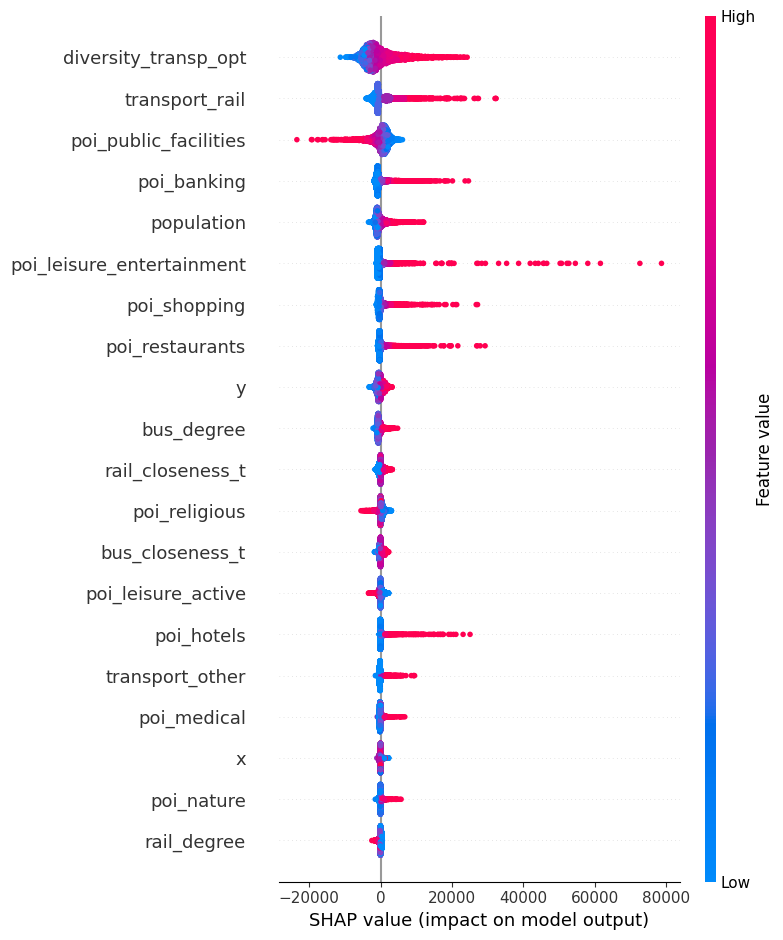

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/5203 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
125/

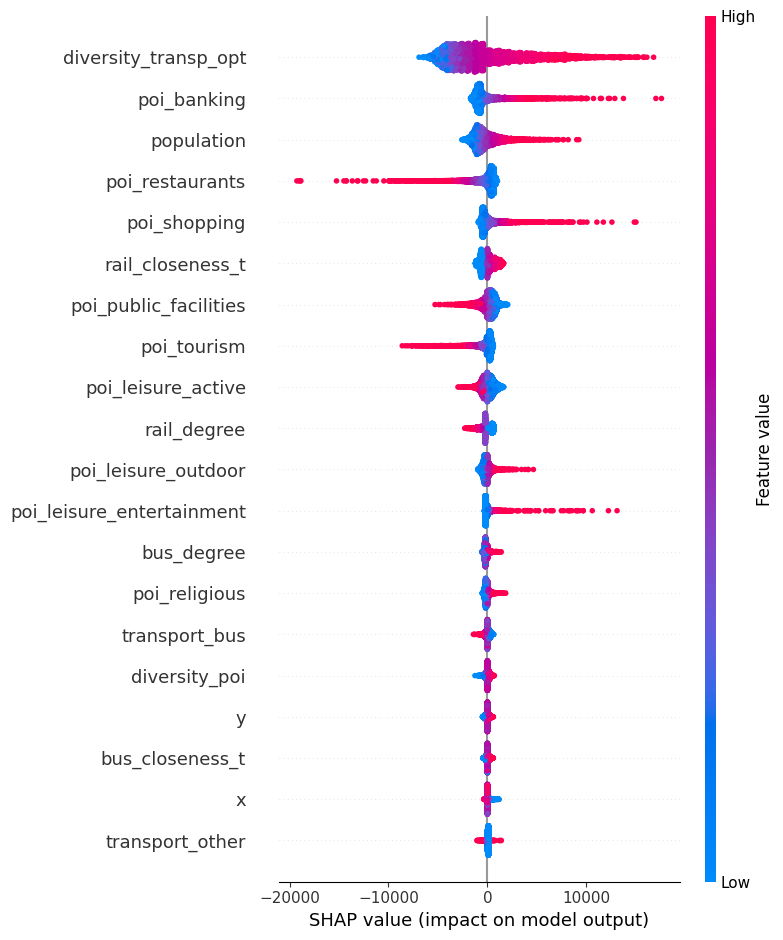

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/5203 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
125/12

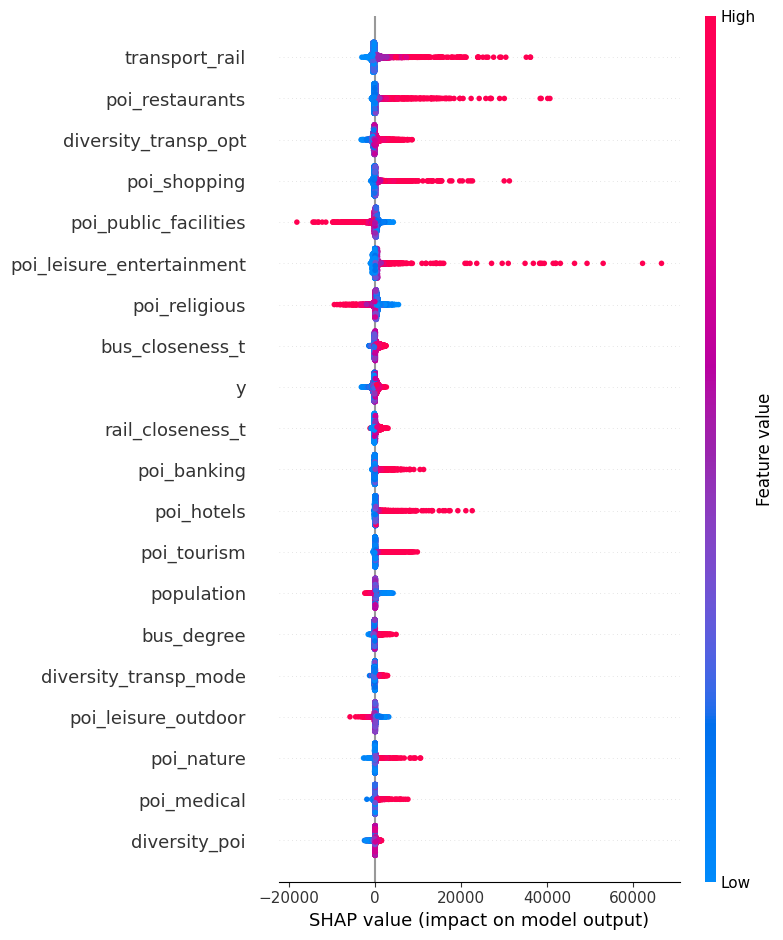

In [18]:
sample = 1000
nsamples = 1000

for target,model in zip(targets,model_list):
    # explain all the predictions in the test set
    explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 20,random_state=random_seed))
    shap_values = explainer.shap_values(X_test, feature_names=features, nsamples=200)
    shap_values = shap_values[:,:,0] # reshape the shap values
    
    # save the shap values to a list
    shap_list.append(shap_values)

    # plot the shap values
    shap.summary_plot(shap_values, X_test,feature_names=features)

In [ ]:
# # Bootstrap SHAP values (to get a the mean and confidence interval)
# from tqdm import tqdm

# shap_bootstrap_list = []

# def boostrap_shap(y_pred):
#     n = y.shape[0]
#     err = y - y_pred
    
#     for i in tqdm(range(5000)):
        
#         random_sample_index = np.random.choice(np.arange(n), size=n, replace=True)
        
#         y_sample = y_pred + err[random_sample_index]
        
#         sample_data = xgboost.DMatrix(X_coords,y_sample)
        
#         sample_model = krmodel.fit()

#         explainer_shap = shap.Explainer(sample_model)
#         shap_values = explainer_shap(features_w_coords)

#         shap_bootstrap_list.append(shap_values.values)
        
#     return np.array(shap_bootstrap_list)

# 2. With log transformation

## 2.1 Correl

Correlation matrix for log_Total_railbus


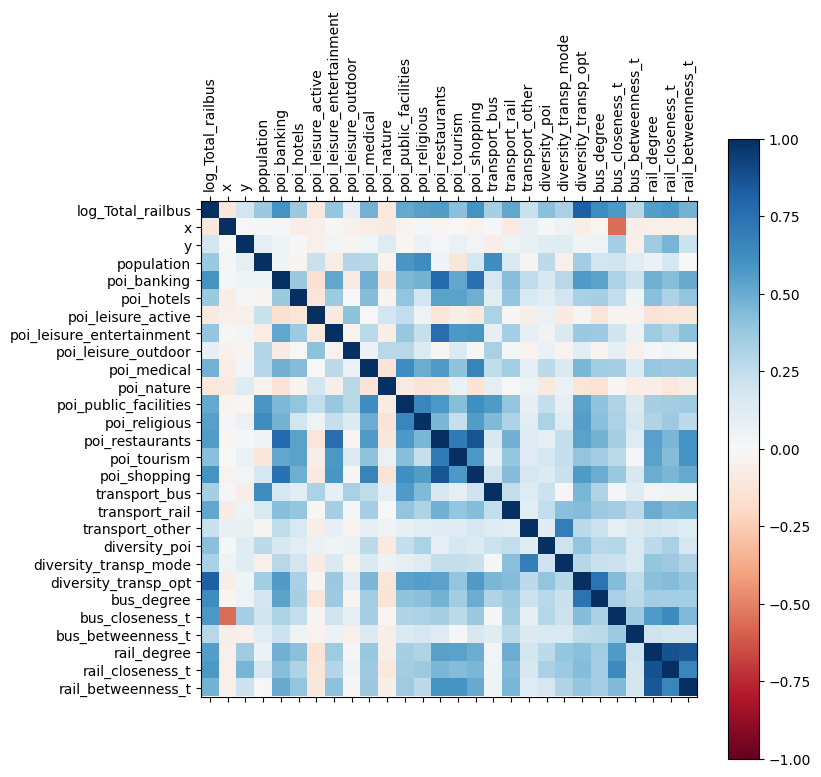

Correlation matrix for log_Total_bus


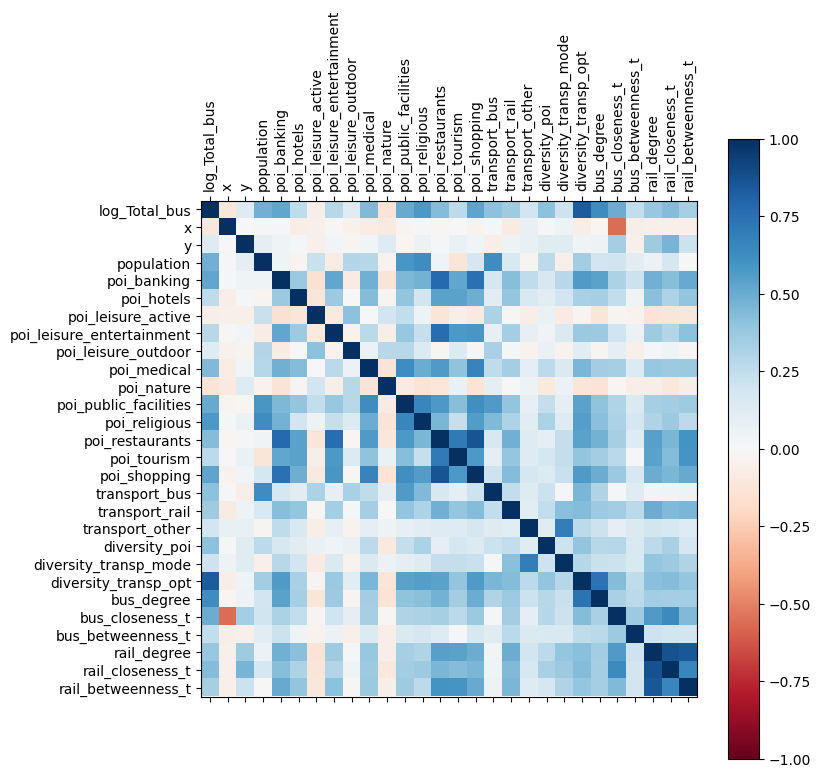

Correlation matrix for log_Total_rail


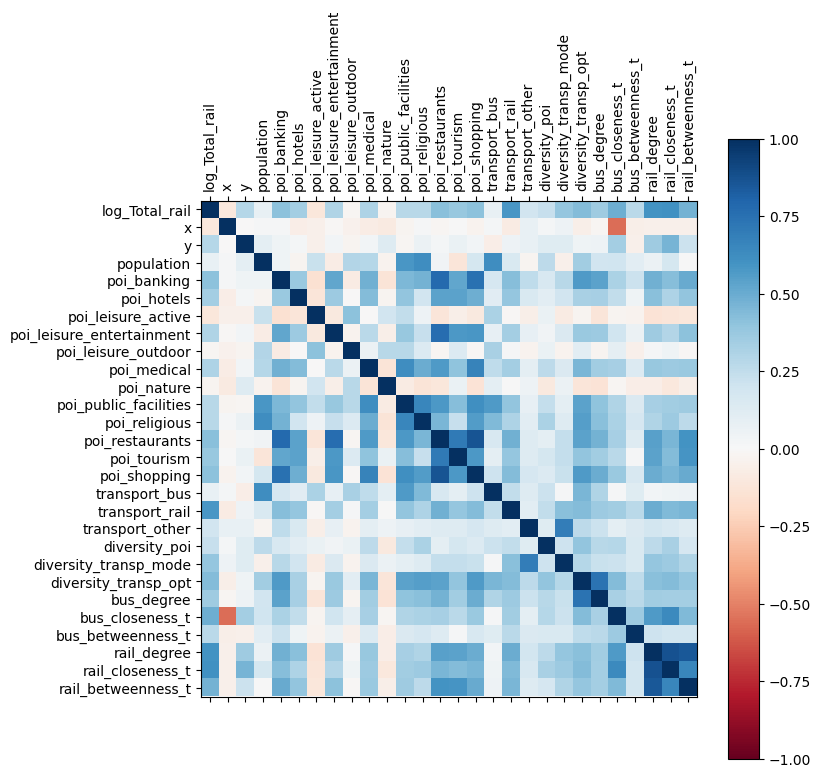

In [ ]:
# for each of the target variable, create a correlation matrix graph
for tar in targets_log: # only log_Total_railbus
    print(f'Correlation matrix for {tar}')
    corr = df[[tar] + features_w_coords].corr()
    plt.figure(figsize=(8,8))
    # set 0 as middle value
    plt.matshow(corr, fignum=1, cmap='RdBu',vmin=-1,vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    
    # save the figure
    plt.savefig(os.path.join('output','corr',f'corr_{tar}_log.jpg'))
    plt.show()

    break

## 2.2 Mapping targets and features

(500950.8766223728, 564298.121720478, 153943.01321221923, 203074.03445197854)

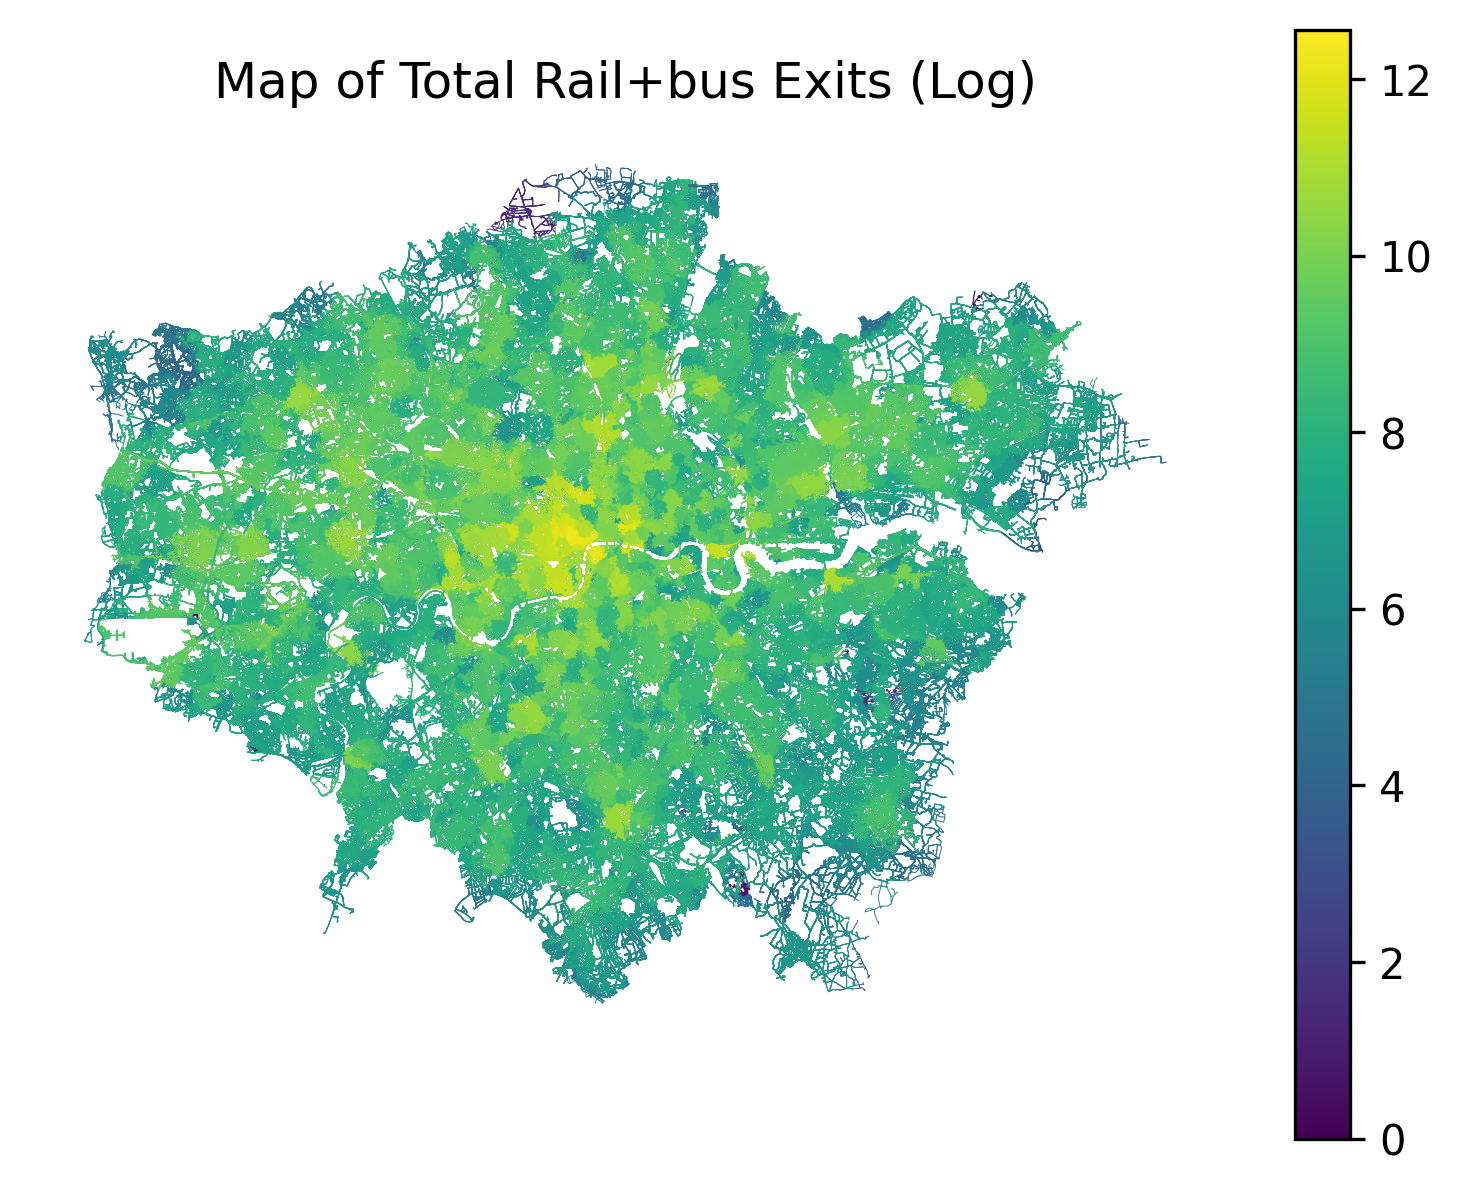

In [25]:
# Map target var
fig, ax = plt.subplots()
df.plot(ax=ax,column='log_Total_railbus',legend=True,figsize=(15,8),cmap='viridis')
plt.title("Map of Total Rail+bus Exits ")
ax.axis('off')

In [ ]:
# Map features (w/o coords)

fig, ax = plt.subplots(5,5,figsize=(20,20))

for j in features:
    ax = ax.ravel()
    
    df.plot(ax=ax[j],column = shap_values.data[:,j+2],legend=True)
    
    ax[j].set_title(features[j],fontsize=14)
    ax[j].axis('off')
    
fig.tight_layout()

### 2.3 Train model

In [47]:
results = pd.DataFrame(columns=['Target var','MSE','R2'])
model_list = []

# fit model
for target in targets_log: # only log_Total_railbus
    print(f'Running model for {target}')
    X= df[features_w_coords]
    y= df[target]

    # Split the data into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

    ### Sandardization of data ###
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # create ANN model
    krmodel = Sequential()
    krmodel.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    krmodel.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    krmodel.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    krmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    # Fitting the ANN to the Training set
    krmodel.fit(X_train, y_train ,batch_size = 20, epochs = 200, verbose=1, validation_data=(X_test, y_test))
    # save the model to a list
    model_list.append(krmodel)
    # predict the test data
    y_pred = krmodel.predict(X_test)

    # how good is the model?
    print(f'MSE: {mean_squared_error(y_test,y_pred)}')
    print(f'R2: {r2_score(y_test,y_pred)}')
    # store the two values MSE and R2 in a dataframe for each target variable
    ddf = pd.DataFrame({'Target var':target,'MSE':mean_squared_error(y_test,y_pred),'R2':r2_score(y_test,y_pred)},index=[0])
    results = pd.concat([results,ddf])

    break

# view general results
results.reset_index(drop=True,inplace=True)
results.to_csv(os.path.join('output','results_kr_xy_log.csv'),index=False)
results

Running model for log_Total_railbus
Epoch 1/200
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 45.2759 - mean_squared_error: 45.2759 - val_loss: 2.2484 - val_mean_squared_error: 2.2488
Epoch 2/200
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7582 - mean_squared_error: 1.7582 - val_loss: 0.9062 - val_mean_squared_error: 0.9056
Epoch 3/200
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8073 - mean_squared_error: 0.8073 - val_loss: 0.5670 - val_mean_squared_error: 0.5673
Epoch 4/200
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5536 - mean_squared_error: 0.5536 - val_loss: 0.4352 - val_mean_squared_error: 0.4363
Epoch 5/200
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4470 - mean_squared_error: 0.4470 - val_loss: 0.3876 - val_mean_squared_error: 0.3887
Epoch 6/200
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3969 - mean_squared_error: 0.3969 - val_loss: 0.3673 - val_mean_squared_error: 0.3682
Epoch 7/200
607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3874 

C:\Users\shaun\AppData\Local\Temp\ipykernel_18928\4088226451.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,ddf])


Target var       MSE        R2
0  log_Total_railbus  0.255779  0.844058

### 2.4 SHAP

In [ ]:
for target,model in zip(targets_log,model_list):
    print(f'Shap plot for {target}')
    # explain all the predictions in the test set
    explainer = shap.Explainer(model, X_train)
    shap_values3 = explainer(X_test)
    # shap_values1 = shap_values[:,:,0] # reshape the shap values

Shap plot for log_Total_railbus


PermutationExplainer explainer:   4%|▍         | 758/17342 [01:04<28:15,  9.78it/s]


KeyboardInterrupt: 

In [ ]:
for target,model in zip(targets_log,model_list):
    print(f'Shap plot for {target}')
    # explain all the predictions in the test set
    explainer = shap.Explainer(model.predict, shap.sample(X_train, 100,random_state=random_seed))
    shap_values1 = explainer(X_test)
    # shap_values1 = shap_values[:,:,0] # reshape the shap values

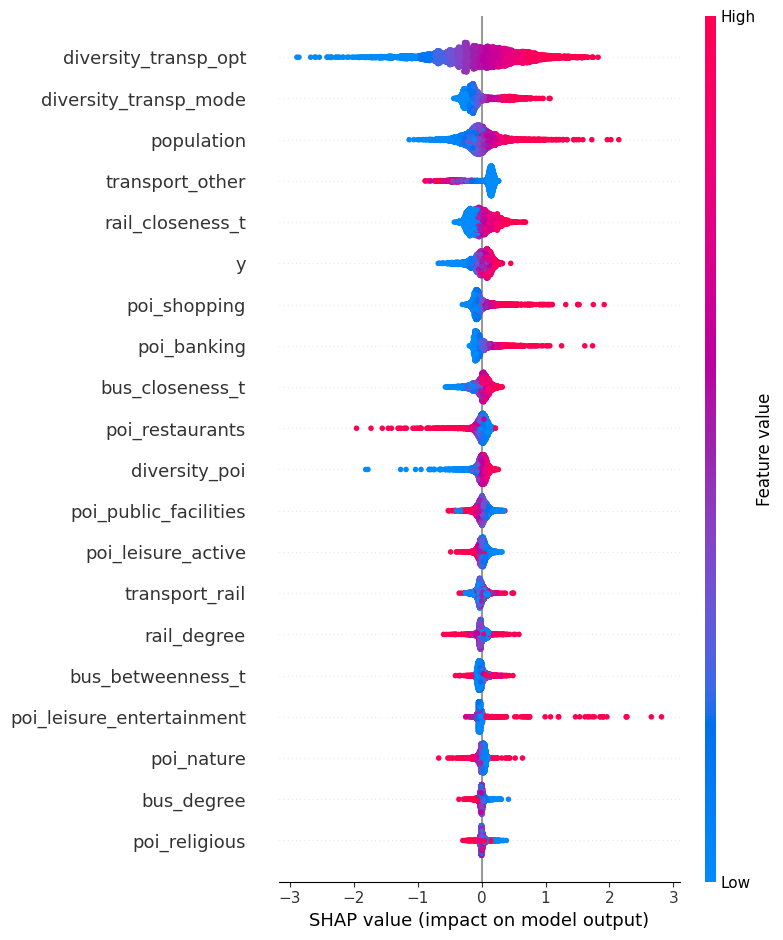

In [112]:
# plot the shap values
shap.summary_plot(shap_values1, X_test,feature_names=features_w_coords)

In [ ]:
# for target,model in zip(targets_log,model_list):
#     print(f'Shap plot for {target}')
#     # explain all the predictions in the test set
#     explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100,random_state=random_seed))
#     shap_values = explainer.shap_values(X_test, feature_names=features, nsamples=250)
#     shap_values = shap_values[:,:,0] # reshape the shap values
    
#     # plot the shap values
#     shap.summary_plot(shap_values, X_test,feature_names=features)

### 2.5 Plot SHAP

#### Global importance

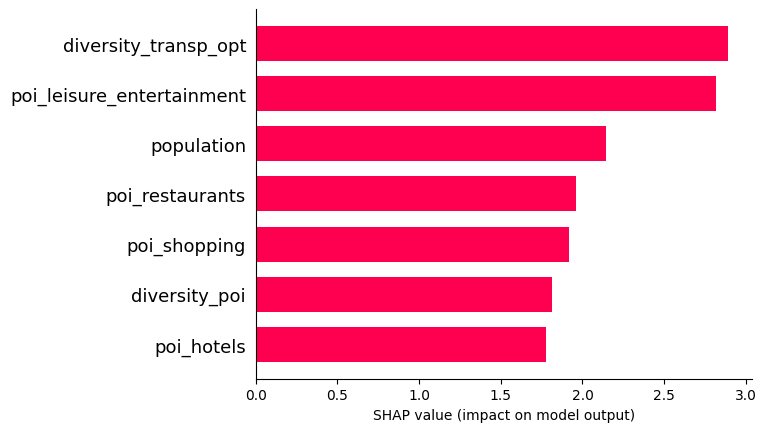

In [109]:
shap.bar_plot(np.abs(shap_values1.values).max(axis=0),feature_names=features_w_coords,show=True)

#### Partial dependence plot for select feature

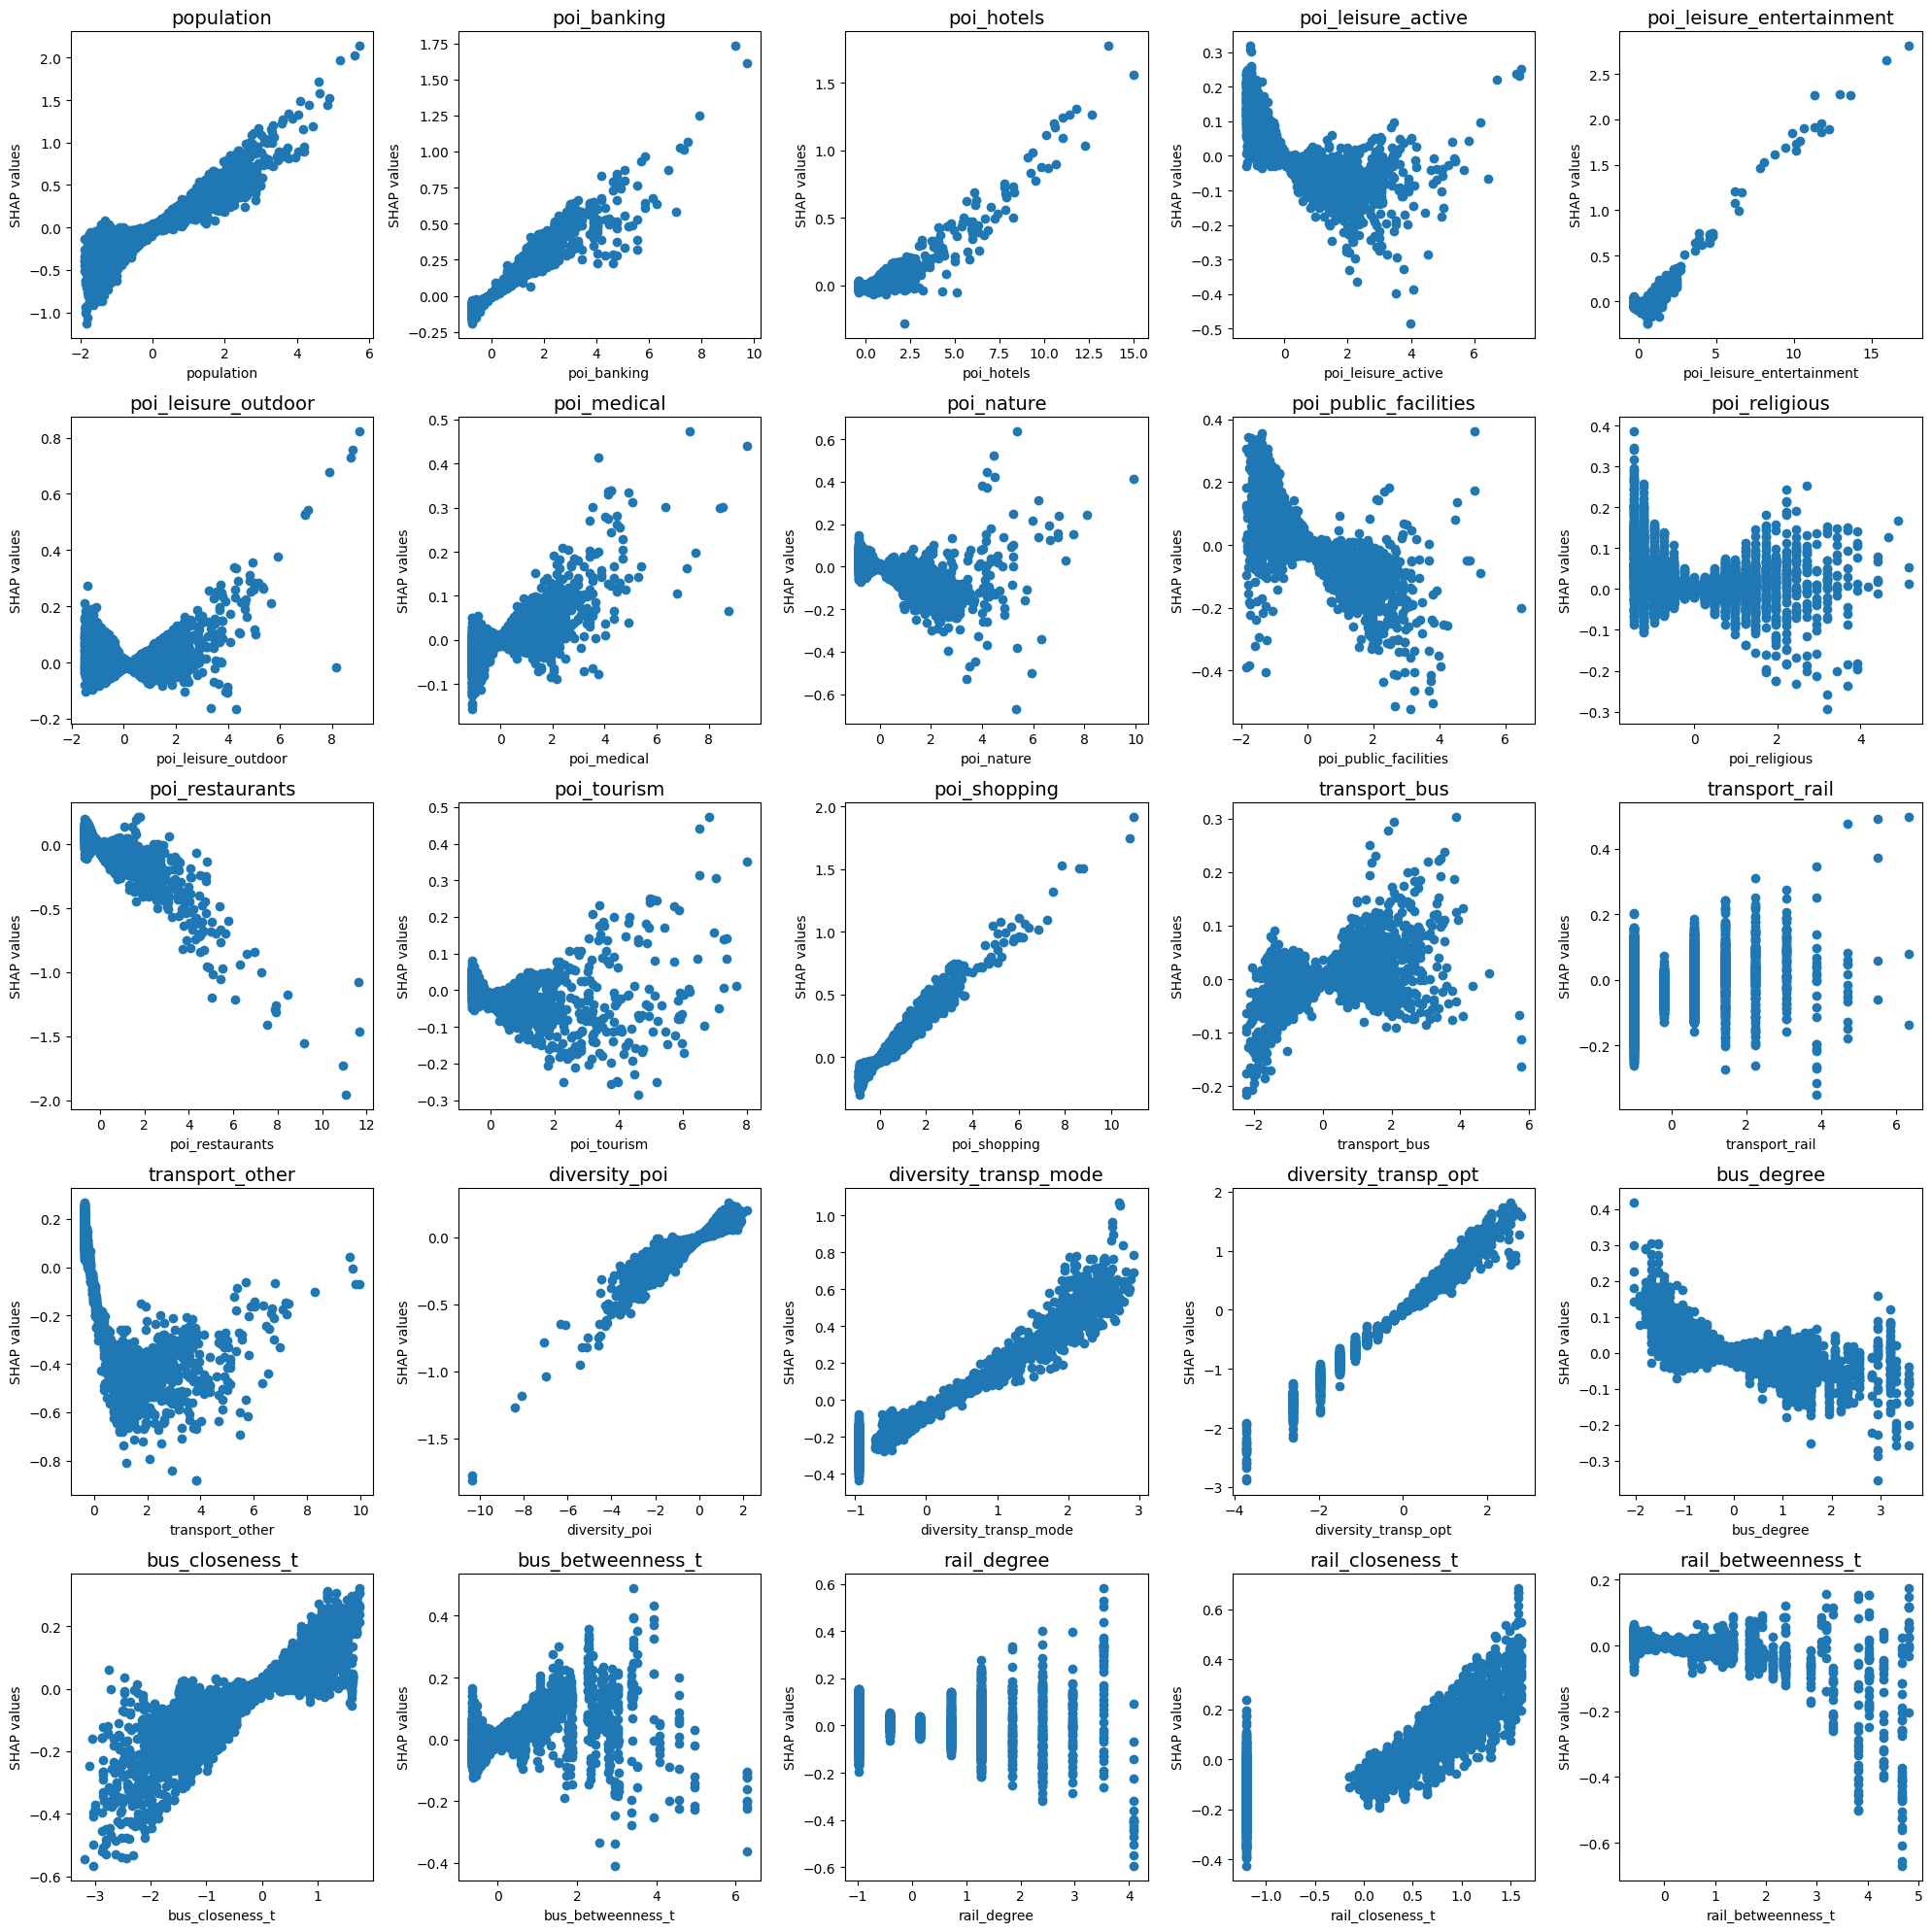

In [121]:
# # Scatter Plot for population feature
# plt.figure(figsize=(10,6))
# plt.scatter(X_test[:,0],shap_values1.values[:,0])
# plt.xlabel('Population')
# plt.ylabel('SHAP values')
# plt.title('Scatter plot for Population feature')
# plt.show()

# Scatter Plot for all features
fig, ax = plt.subplots(5,5,figsize=(20,20))

for j in range(25):
    ax = ax.ravel()
    
    ax[j].scatter(X_test[:,j+2],shap_values1.values[:,j+2])
    ax[j].set_title(features[j],fontsize=14)
    ax[j].set_xlabel(features[j])
    ax[j].set_ylabel('SHAP values')

fig.tight_layout()

#### Spatial patterns of SHAP values

In [122]:
shap_values2.values[:,:].shape

(17342, 27)

In [124]:
X.values[:,:].shape

(17342, 27)

In [131]:
fig, ax = plt.subplots(5,5,figsize=(50,50)) # All 25 features excluding x and y coordinates

for j in range(len(features)):
    ax = ax.ravel()
    df.plot(ax=ax[j],column = shap_values2.values[:,j+2],legend=True, # excluding x and y coordinates, the first two columns
            cmap=shap.plots.colors.red_white_blue)
    
    ax[j].set_title("SHAP for\n" + features[j],fontsize=10)
    


#### Location Effect Map

(500950.8766223728, 564298.121720478, 153943.01321221923, 203074.03445197854)

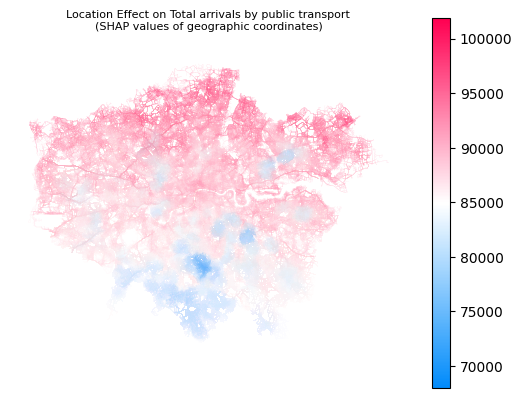

In [130]:
fig, ax = plt.subplots()

df.plot(ax=ax,column = shap_values2.values[:,0] + shap_values2.values[:,1], # x and y coordinates
             legend=True,cmap=shap.plots.colors.red_white_blue,alpha=0.2)

plt.title("Location Effect on Total arrivals by public transport\n(SHAP values of geographic coordinates)\n",fontsize=8)
plt.axis('off')

# 3. MGWR

In [ ]:
from mgwr.gwr import GWR,MGWR                                                   
from mgwr.sel_bw import Sel_BW   

In [ ]:
# # define target variable columns
# targets = ['Total_railbus','Total_bus','Total_rail']
# targets_log = ['log_Total_railbus','log_Total_bus','log_Total_rail']
# # targets_tb_r = ['Early_rail', 'AM Peak_rail', 'Midday_rail', 'PM Peak_rail', 'Evening_rail', 'Late_rail']

# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'bus_degree','bus_closeness_t','bus_betweenness_t',
            'rail_degree','rail_closeness_t','rail_betweenness_t'
            ]

In [ ]:
#rename x and y coordinates to x_coords and y_coords
df.rename(columns={'x':'x_coords','y':'y_coords'},inplace=True)


In [ ]:
X = df[features]
X_coords = df[features + ['x_coords','y_corrds']]
X_std = (X - X.mean(axis=0)) # data mean centering

coords = df[['x_coords','y_corrds']].values

y = df['log_Total_railbus']
y_std = y #Data Mean centering

In [ ]:
%%time
sel = Sel_BW(coords,y_std.values.reshape(-1,1),X_std.values,multi=True)
bws = sel.search(verbose=False)
result_mgwr = MGWR(coords,y_std.values.reshape(-1,1),X_std.values,selector=sel).fit()

In [ ]:
result_mgwr.summary()

# 4. GWR

In [ ]:
# Prepare dataset inputs - Crime
g_y = df["log_Total_railbus"].values.reshape((-1, 1))
g_X = df[features].values
g_coords = df[['x','y']].values

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

# Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)

In [ ]:
# gwr_bw = 504  # I calibrated this
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [ ]:
# Add Paramaters back to geo dataframe for mapping
df["gwr_intercept"] = gwr_results.params[:, 0]
for i in range(len(features)):
    df["gwr_" + features[i]] = gwr_results.params[:, i + 1]

# Filter Insignificant coefficients alpha 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha=0.05)

In [ ]:
# plot population

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
df.plot(
        #first feature
        column="gwr_" + features[0],
        cmap="RdBu_r",
        linewidth=0.001,
        scheme="naturalbreaks",
        k=4,
        legend=True,
        legend_kwds={"bbox_to_anchor": (1.10, 0.2)},
        ax=axes[0],
    )

lsoa[gwr_filtered_t[:, i] == 0].plot(
        color="white", linewidth=0.001, edgecolor="white", ax=axes[1]
    )  
